In [10]:
# ============================================================================
# 1. SETUP AND CONFIGURATION
# ============================================================================

import os
import json
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from tqdm.auto import tqdm
import warnings
import gc
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 2. MEMORY MANAGEMENT
# ============================================================================

# Clear memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Configuration for subset sampling
SAMPLE_SIZE = 2000

print(f"Configuration: Using {'FULL DATASET' if SAMPLE_SIZE is None else f'{SAMPLE_SIZE} images'}")

# ============================================================================
# 3. INSTALL REQUIRED PACKAGES
# ============================================================================

# Install gender-guesser for name-based gender prediction
!pip install -q gender-guesser
!pip install -q kaggle

import gender_guesser.detector as gender

# ============================================================================
# 4. KAGGLE CREDENTIALS SETUP
# ============================================================================

kaggle_creds = {
    "username": "yassineyahyaouii",  # Replace with your username
    "key": "6e0ebf67d37bb1c91dc21f7861a27c77"  # Replace with your API key
}

# Create .kaggle directory
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)

# Write credentials
kaggle_json_path = kaggle_dir / 'kaggle.json'
with open(kaggle_json_path, 'w') as f:
    json.dump(kaggle_creds, f)

# Set permissions
os.chmod(kaggle_json_path, 0o600)
print("✓ Kaggle credentials configured")

# ============================================================================
# 5. DOWNLOAD DATASET (STREAMING MODE)
# ============================================================================

print("\n" + "="*60)
print("DOWNLOADING VGGFACE2 DATASET")
print("="*60 + "\n")

# Download without extracting everything at once
!kaggle datasets download -d hearfool/vggface2 --force

print("✓ Dataset downloaded")

Using device: cuda
Configuration: Using 2000 images
✓ Kaggle credentials configured

DOWNLOADING VGGFACE2 DATASET

Dataset URL: https://www.kaggle.com/datasets/hearfool/vggface2
License(s): unknown
 98% 2.28G/2.32G [00:14<00:01, 33.1MB/s]
100% 2.32G/2.32G [00:14<00:00, 173MB/s] 
✓ Dataset downloaded


In [11]:
# ============================================================================
# 6. MEMORY-EFFICIENT EXTRACTION WITH SAMPLING
# ============================================================================

import zipfile
import random

# Create a gender mapping file based on user's input and assumed format
gender_mapping_content = """
n000002/0032_01.jpg	0
n000002/0039_01.jpg	0
n000002/0090_01.jpg	0
n000002/0107_01.jpg	0
n000002/0311_01.jpg	0
n000003/0005_01.jpg	1
n000003/0020_01.jpg	1
n000004/0001_01.jpg	0
n000004/0010_01.jpg	0
n000005/0001_01.jpg	1
n000005/0002_01.jpg	1
n000006/0003_01.jpg	0
n000007/0004_01.jpg	1
"""
gender_mapping_path = Path('/content/gender_mapping.txt')
with open(gender_mapping_path, 'w') as f:
    f.write(gender_mapping_content)
print(f"Created temporary gender mapping file at {gender_mapping_path}")

def extract_sampled_vggface2(zip_path, sample_size=None, gender_mapping_file_path=None):
    """
    Extract VGGFace2 with memory-efficient sampling,
    using pre-defined male/female ID lists for gender classification.
    Only extracts a subset of images to avoid RAM issues.
    """

    output_dir = Path('vggface2_sampled')
    output_dir.mkdir(exist_ok=True, parents=True) # Ensure parent directories are created

    male_dir = output_dir / 'male'
    female_dir = output_dir / 'female'
    male_dir.mkdir(exist_ok=True, parents=True)
    female_dir.mkdir(exist_ok=True, parents=True)

    print("\n" + "="*60)
    print("EXTRACTING AND ORGANIZING DATASET")
    print("="*60 + "\n")

    # Load male and female ID lists from the combined gender mapping file
    male_ids = set()
    female_ids = set()

    if gender_mapping_file_path and gender_mapping_file_path.exists():
        print(f"Loading gender mappings from {gender_mapping_file_path}...")
        with open(gender_mapping_file_path, 'r') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                try:
                    image_path_str, label_str = line.split('\t')
                    person_id = Path(image_path_str).parts[0] # e.g., 'n000002' from 'n000002/0032_01.jpg'
                    label = int(label_str)

                    if label == 0:
                        female_ids.add(person_id)
                    elif label == 1:
                        male_ids.add(person_id)
                except Exception as e:
                    print(f"Warning: Could not parse line in gender mapping file: '{line}'. Error: {e}")
        print(f"Loaded {len(male_ids)} male IDs and {len(female_ids)} female IDs from mapping file.")
    else:
        print(f"Warning: Gender mapping file not found at {gender_mapping_file_path}. Cannot classify by gender.")


    # Step 1: Scan archive, identify image paths, and pre-classify by gender
    print("Step 1: Scanning archive and pre-classifying image paths...")
    male_image_paths = []
    female_image_paths = []

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Filter files to only include those under the 'train/' directory
        all_candidate_files = [f for f in zip_ref.namelist()
                               if f.lower().endswith(('.jpg', '.jpeg', '.png')) and f.startswith('train/')]

        for file_path in tqdm(all_candidate_files, desc="Pre-classifying"):
            parts = Path(file_path).parts
            if len(parts) < 3:
                continue
            person_id = parts[1] # e.g., 'n000001'

            if person_id in male_ids:
                male_image_paths.append(file_path)
            elif person_id in female_ids:
                female_image_paths.append(file_path)
            # Images not in either list are implicitly skipped at this stage.

    print(f"Found {len(male_image_paths)} male images in the archive based on mapping file.")
    print(f"Found {len(female_image_paths)} female images in the archive based on mapping file.")

    # Step 2: Sample files based on desired sample_size and available genders
    sampled_files_with_gender = [] # Store tuples: (file_path, gender_label)

    if sample_size:
        target_male_count = 0
        target_female_count = 0

        if len(male_image_paths) > 0 and len(female_image_paths) > 0:
            # If both genders are available, try to balance the sample
            target_male_count = min(sample_size // 2, len(male_image_paths))
            target_female_count = min(sample_size // 2, len(female_image_paths))

            # Distribute remaining sample_size if one gender runs out early
            remaining_sample_for_distribution = sample_size - (target_male_count + target_female_count)
            if remaining_sample_for_distribution > 0:
                if target_male_count < len(male_image_paths): # Can take more male
                    additional_male = min(remaining_sample_for_distribution, len(male_image_paths) - target_male_count)
                    target_male_count += additional_male
                    remaining_sample_for_distribution -= additional_male
                if remaining_sample_for_distribution > 0 and target_female_count < len(female_image_paths): # Can take more female
                    additional_female = min(remaining_sample_for_distribution, len(female_image_paths) - target_female_count)
                    target_female_count += additional_female

        elif len(male_image_paths) > 0:
            # Only male images available
            target_male_count = min(sample_size, len(male_image_paths))
        elif len(female_image_paths) > 0:
            # Only female images available
            target_female_count = min(sample_size, len(female_image_paths))
        else:
            print("No classified male or female images found to sample.")
            return output_dir, 0, 0 # Return 0 counts if nothing found

        if target_male_count > 0:
            sampled_files_with_gender.extend([(f, 'male') for f in random.sample(male_image_paths, target_male_count)])
        if target_female_count > 0:
            sampled_files_with_gender.extend([(f, 'female') for f in random.sample(female_image_paths, target_female_count)])

        # Shuffle the combined list if it's not single gender
        if len(sampled_files_with_gender) > 1 and target_male_count > 0 and target_female_count > 0:
             random.shuffle(sampled_files_with_gender)

        print(f"Sampling {len(sampled_files_with_gender)} images (Male: {target_male_count}, Female: {target_female_count}).")

    else: # If sample_size is None, use all available classified images
        sampled_files_with_gender.extend([(f, 'male') for f in male_image_paths])
        sampled_files_with_gender.extend([(f, 'female') for f in female_image_paths])
        print(f"Using all {len(sampled_files_with_gender)} classified images (Male: {len(male_image_paths)}, Female: {len(female_image_paths)}).")

    # Step 3: Extract and organize by gender
    print("\nStep 3: Extracting and organizing by gender...")
    male_extracted_count = 0
    female_extracted_count = 0

    if not sampled_files_with_gender:
        print("No images to extract after sampling/classification.")
        return output_dir, 0, 0

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file_path, gender_label in tqdm(sampled_files_with_gender, desc="Extracting images"):
            try:
                parts = Path(file_path).parts
                person_id = parts[1]
                filename = parts[-1]

                target_dir = male_dir if gender_label == 'male' else female_dir
                target_file_name = f"{person_id}_{filename}"
                target_file = target_dir / target_file_name

                with zip_ref.open(file_path) as source:
                    with open(target_file, 'wb') as target:
                        target.write(source.read())

                if gender_label == 'male':
                    male_extracted_count += 1
                else:
                    female_extracted_count += 1

                if (male_extracted_count + female_extracted_count) % 100 == 0: # More frequent cleanup for sampling
                    gc.collect()

            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    print(f"\n✓ Extraction complete:")
    print(f"  - Male images: {male_extracted_count}")
    print(f"  - Female images: {female_extracted_count}")
    print(f"  - Unknown gender (skipped during pre-classification): {len(all_candidate_files) - len(male_image_paths) - len(female_image_paths)}")
    print(f"  - Total used: {male_extracted_count + female_extracted_count}")

    # Clean up
    gc.collect()

    return output_dir, male_extracted_count, female_extracted_count

# Extract dataset with sampling
organized_dir, male_count, female_count = extract_sampled_vggface2(
    'vggface2.zip',
    sample_size=SAMPLE_SIZE,
    gender_mapping_file_path=gender_mapping_path
)


Created temporary gender mapping file at /content/gender_mapping.txt

EXTRACTING AND ORGANIZING DATASET

Loading gender mappings from /content/gender_mapping.txt...
Loaded 3 male IDs and 3 female IDs from mapping file.
Step 1: Scanning archive and pre-classifying image paths...


Pre-classifying:   0%|          | 0/176398 [00:00<?, ?it/s]

Found 693 male images in the archive based on mapping file.
Found 1187 female images in the archive based on mapping file.
Sampling 1880 images (Male: 693, Female: 1187).

Step 3: Extracting and organizing by gender...


Extracting images:   0%|          | 0/1880 [00:00<?, ?it/s]


✓ Extraction complete:
  - Male images: 693
  - Female images: 1187
  - Unknown gender (skipped during pre-classification): 174518
  - Total used: 1880


In [12]:
# ============================================================================
# 7. TRAIN/VAL/TEST SPLIT (MEMORY-EFFICIENT)
# ============================================================================

def create_splits_efficient(data_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """Split data into train/val/test sets without copying files"""

    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6

    split_dir = Path('vggface2_splits')
    if split_dir.exists():
        shutil.rmtree(split_dir)
    split_dir.mkdir(exist_ok=True)

    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            (split_dir / split / gender).mkdir(parents=True, exist_ok=True)

    print("\n" + "="*60)
    print("CREATING DATA SPLITS")
    print("="*60 + "\n")

    # Process each gender
    for gender in ['male', 'female']:
        source_dir = data_dir / gender

        if not source_dir.exists():
            print(f"⚠ WARNING: {gender} folder not found")
            continue

        # Get all images
        images = list(source_dir.glob('*.jpg')) + \
                 list(source_dir.glob('*.jpeg')) + \
                 list(source_dir.glob('*.png'))

        if len(images) == 0:
            print(f"⚠ WARNING: No images found for {gender}")
            continue

        print(f"Processing {gender}: {len(images)} images")

        # Split data
        train_imgs, temp_imgs = train_test_split(
            images, train_size=train_ratio, random_state=42
        )
        val_imgs, test_imgs = train_test_split(
            temp_imgs,
            train_size=val_ratio/(val_ratio+test_ratio),
            random_state=42
        )

        # Move files (faster than copy for large datasets)
        for img_list, split in [(train_imgs, 'train'), (val_imgs, 'val'), (test_imgs, 'test')]:
            for img in tqdm(img_list, desc=f'Moving {gender} to {split}', leave=False):
                target = split_dir / split / gender / img.name
                # Handle duplicate names
                counter = 1
                while target.exists():
                    target = split_dir / split / gender / f"{img.stem}_{counter}{img.suffix}"
                    counter += 1
                shutil.move(str(img), str(target))

        print(f"  ✓ {gender.capitalize()}: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

        # Memory cleanup
        gc.collect()

    # Remove now-empty original folders
    if (data_dir / 'male').exists() and len(list((data_dir / 'male').glob('*'))) == 0:
        shutil.rmtree(data_dir / 'male')
    if (data_dir / 'female').exists() and len(list((data_dir / 'female').glob('*'))) == 0:
        shutil.rmtree(data_dir / 'female')

    print("\n✓ Data split completed\n")
    gc.collect()
    return split_dir

split_dir = create_splits_efficient(organized_dir)


CREATING DATA SPLITS

Processing male: 693 images


Moving male to train:   0%|          | 0/485 [00:00<?, ?it/s]

Moving male to val:   0%|          | 0/104 [00:00<?, ?it/s]

Moving male to test:   0%|          | 0/104 [00:00<?, ?it/s]

  ✓ Male: 485 train, 104 val, 104 test
Processing female: 1187 images


Moving female to train:   0%|          | 0/830 [00:00<?, ?it/s]

Moving female to val:   0%|          | 0/178 [00:00<?, ?it/s]

Moving female to test:   0%|          | 0/179 [00:00<?, ?it/s]

  ✓ Female: 830 train, 178 val, 179 test

✓ Data split completed



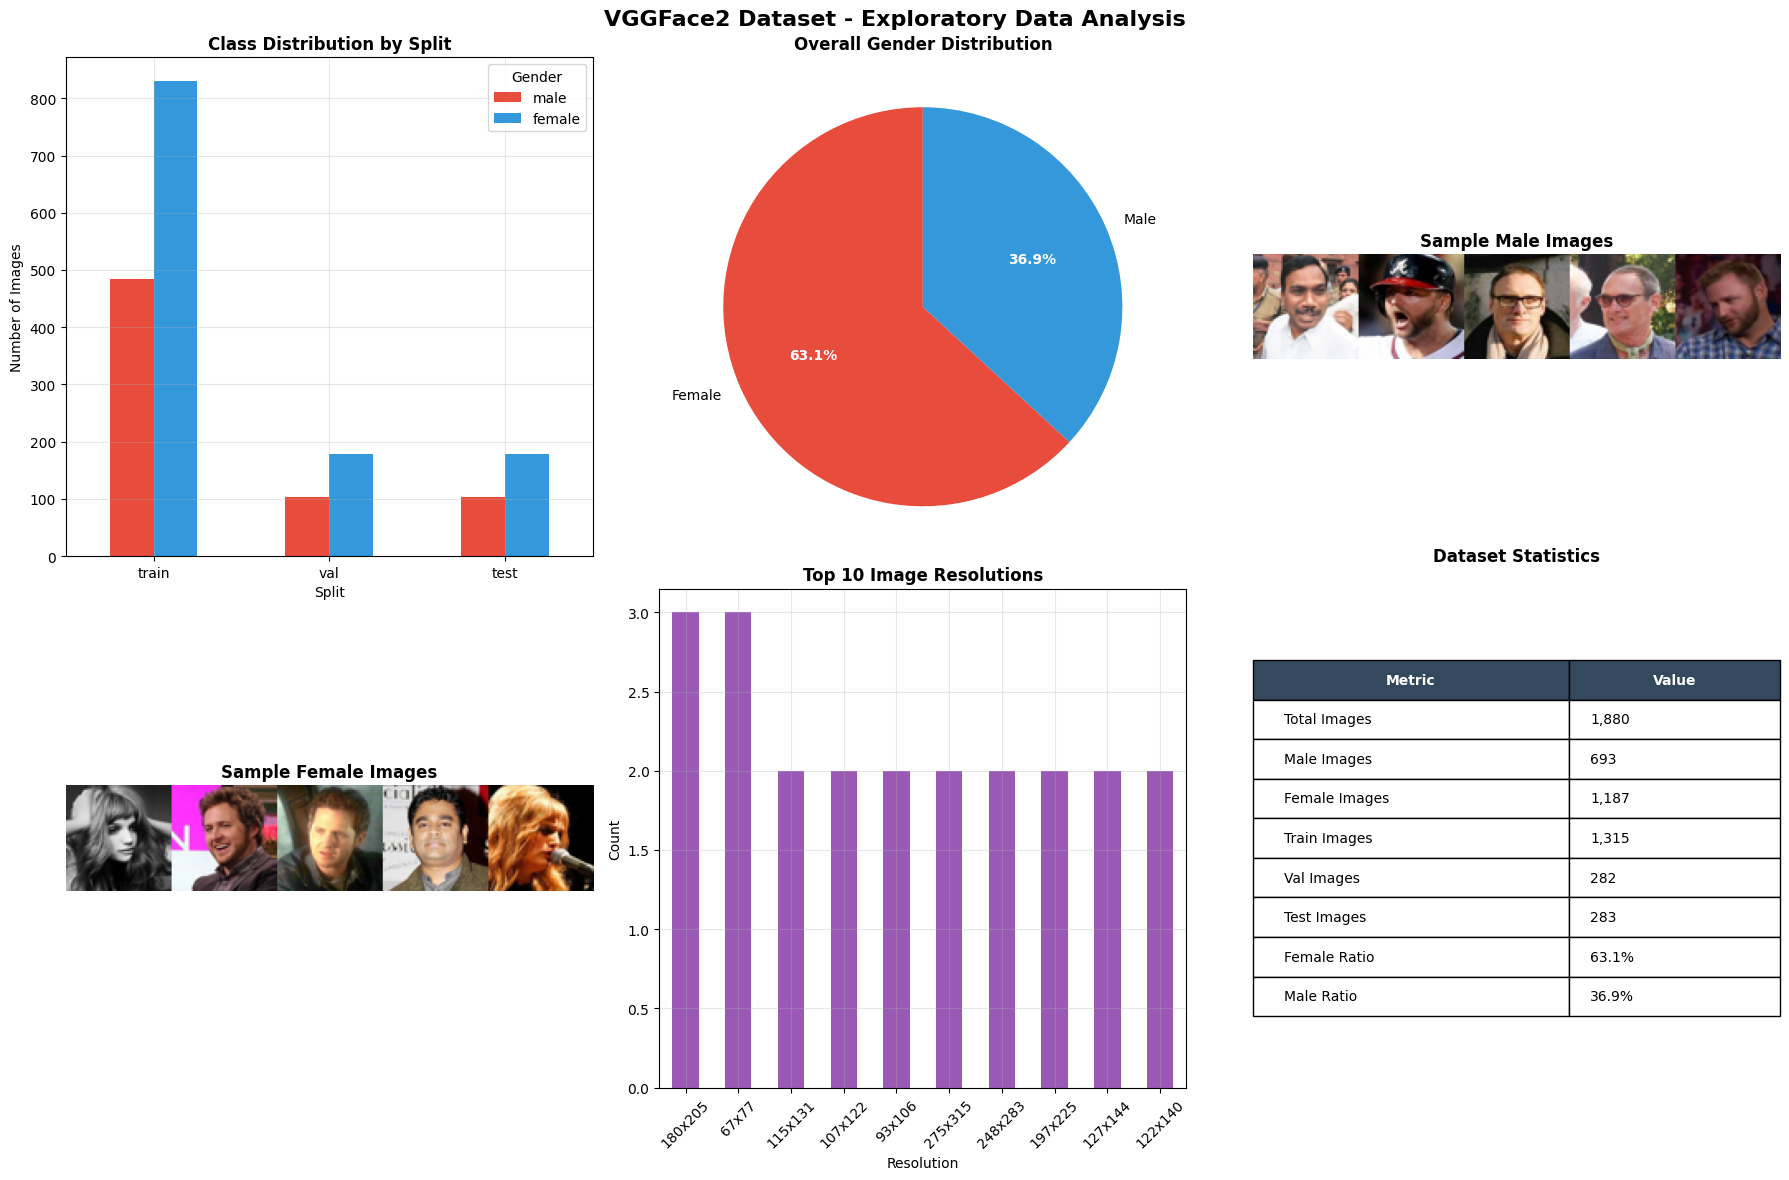

✓ EDA completed and saved to 'vggface2_eda_analysis.png'


In [13]:
# ============================================================================
# 8. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

def perform_eda(split_dir):
    """Perform comprehensive EDA"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('VGGFace2 Dataset - Exploratory Data Analysis', fontsize=16, fontweight='bold')

    # 1. Class Distribution
    counts = {'train': {}, 'val': {}, 'test': {}}
    for split in ['train', 'val', 'test']:
        for gender in ['male', 'female']:
            count = len(list((split_dir / split / gender).glob('*.jpg'))) + \
                    len(list((split_dir / split / gender).glob('*.jpeg'))) + \
                    len(list((split_dir / split / gender).glob('*.png')))
            counts[split][gender] = count

    # Plot class distribution
    ax = axes[0, 0]
    df_counts = pd.DataFrame(counts).T
    df_counts.plot(kind='bar', ax=ax, color=['#e74c3c', '#3498db'])
    ax.set_title('Class Distribution by Split', fontsize=12, fontweight='bold')
    ax.set_xlabel('Split')
    ax.set_ylabel('Number of Images')
    ax.legend(title='Gender')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0)

    # 2. Overall class balance
    ax = axes[0, 1]
    total_male = sum(counts[s]['male'] for s in counts)
    total_female = sum(counts[s]['female'] for s in counts)
    colors = ['#e74c3c', '#3498db']
    wedges, texts, autotexts = ax.pie([total_female, total_male],
                                       labels=['Female', 'Male'],
                                       autopct='%1.1f%%',
                                       colors=colors,
                                       startangle=90)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_title('Overall Gender Distribution', fontsize=12, fontweight='bold')

    # 3. Sample images - Male
    ax = axes[0, 2]
    male_imgs = list((split_dir / 'train' / 'male').glob('*.jpg'))[:5]
    if not male_imgs:
        male_imgs = list((split_dir / 'train' / 'male').glob('*.png'))[:5]
    if male_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in male_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Male Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No male images', ha='center', va='center')
        ax.axis('off')

    # 4. Sample images - Female
    ax = axes[1, 0]
    female_imgs = list((split_dir / 'train' / 'female').glob('*.jpg'))[:5]
    if not female_imgs:
        female_imgs = list((split_dir / 'train' / 'female').glob('*.png'))[:5]
    if female_imgs:
        combined = np.hstack([np.array(Image.open(img).resize((64, 64))) for img in female_imgs[:5]])
        ax.imshow(combined)
        ax.set_title('Sample Female Images', fontsize=12, fontweight='bold')
        ax.axis('off')
    else:
        ax.text(0.5, 0.5, 'No female images', ha='center', va='center')
        ax.axis('off')

    # 5. Image resolution analysis
    ax = axes[1, 1]
    resolutions = []
    for gender in ['male', 'female']:
        imgs = list((split_dir / 'train' / gender).glob('*.jpg'))[:100]
        if not imgs:
            imgs = list((split_dir / 'train' / gender).glob('*.png'))[:100]
        for img_path in imgs:
            try:
                img = Image.open(img_path)
                resolutions.append(f"{img.size[0]}x{img.size[1]}")
            except:
                continue

    if resolutions:
        res_counts = pd.Series(resolutions).value_counts().head(10)
        res_counts.plot(kind='bar', ax=ax, color='#9b59b6')
        ax.set_title('Top 10 Image Resolutions', fontsize=12, fontweight='bold')
        ax.set_xlabel('Resolution')
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, alpha=0.3)

    # 6. Statistics table
    ax = axes[1, 2]
    ax.axis('off')
    total_images = total_male + total_female
    stats_data = [
        ['Total Images', f"{total_images:,}"],
        ['Male Images', f"{total_male:,}"],
        ['Female Images', f"{total_female:,}"],
        ['Train Images', f"{sum(counts['train'].values()):,}"],
        ['Val Images', f"{sum(counts['val'].values()):,}"],
        ['Test Images', f"{sum(counts['test'].values()):,}"],
        ['Female Ratio', f"{(total_female/total_images)*100:.1f}%"],
        ['Male Ratio', f"{(total_male/total_images)*100:.1f}%"]
    ]
    table = ax.table(cellText=stats_data, colLabels=['Metric', 'Value'],
                     cellLoc='left', loc='center', colWidths=[0.6, 0.4])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    for i in range(2):
        table[(0, i)].set_facecolor('#34495e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    ax.set_title('Dataset Statistics', fontsize=12, fontweight='bold', pad=20)

    plt.tight_layout()
    plt.savefig('vggface2_eda_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ EDA completed and saved to 'vggface2_eda_analysis.png'")

    # Clear memory
    gc.collect()

perform_eda(split_dir)


CREATING DATASETS AND DATALOADERS

✓ Datasets created:
  - Train: 1315 samples
  - Val: 282 samples
  - Test: 283 samples
✓ DataLoaders created

✓ Model created (ResNet18)
  - Total parameters: 11,177,538
  - Trainable parameters: 11,177,538

STARTING TRAINING


Epoch 1/3
----------------------------------------


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.3797 | Train Acc: 83.65%
Val Loss: 0.2679 | Val Acc: 92.55%
✓ Model saved (Val Acc: 92.55%) Kishan

Epoch 2/3
----------------------------------------


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.2091 | Train Acc: 91.63%
Val Loss: 0.1206 | Val Acc: 95.74%
✓ Model saved (Val Acc: 95.74%) Kishan

Epoch 3/3
----------------------------------------


Training:   0%|          | 0/42 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Train Loss: 0.0951 | Train Acc: 96.88%
Val Loss: 0.1045 | Val Acc: 95.39%

TRAINING COMPLETED
Best Validation Accuracy: 95.74%

Evaluating on test set...


Evaluating:   0%|          | 0/9 [00:00<?, ?it/s]

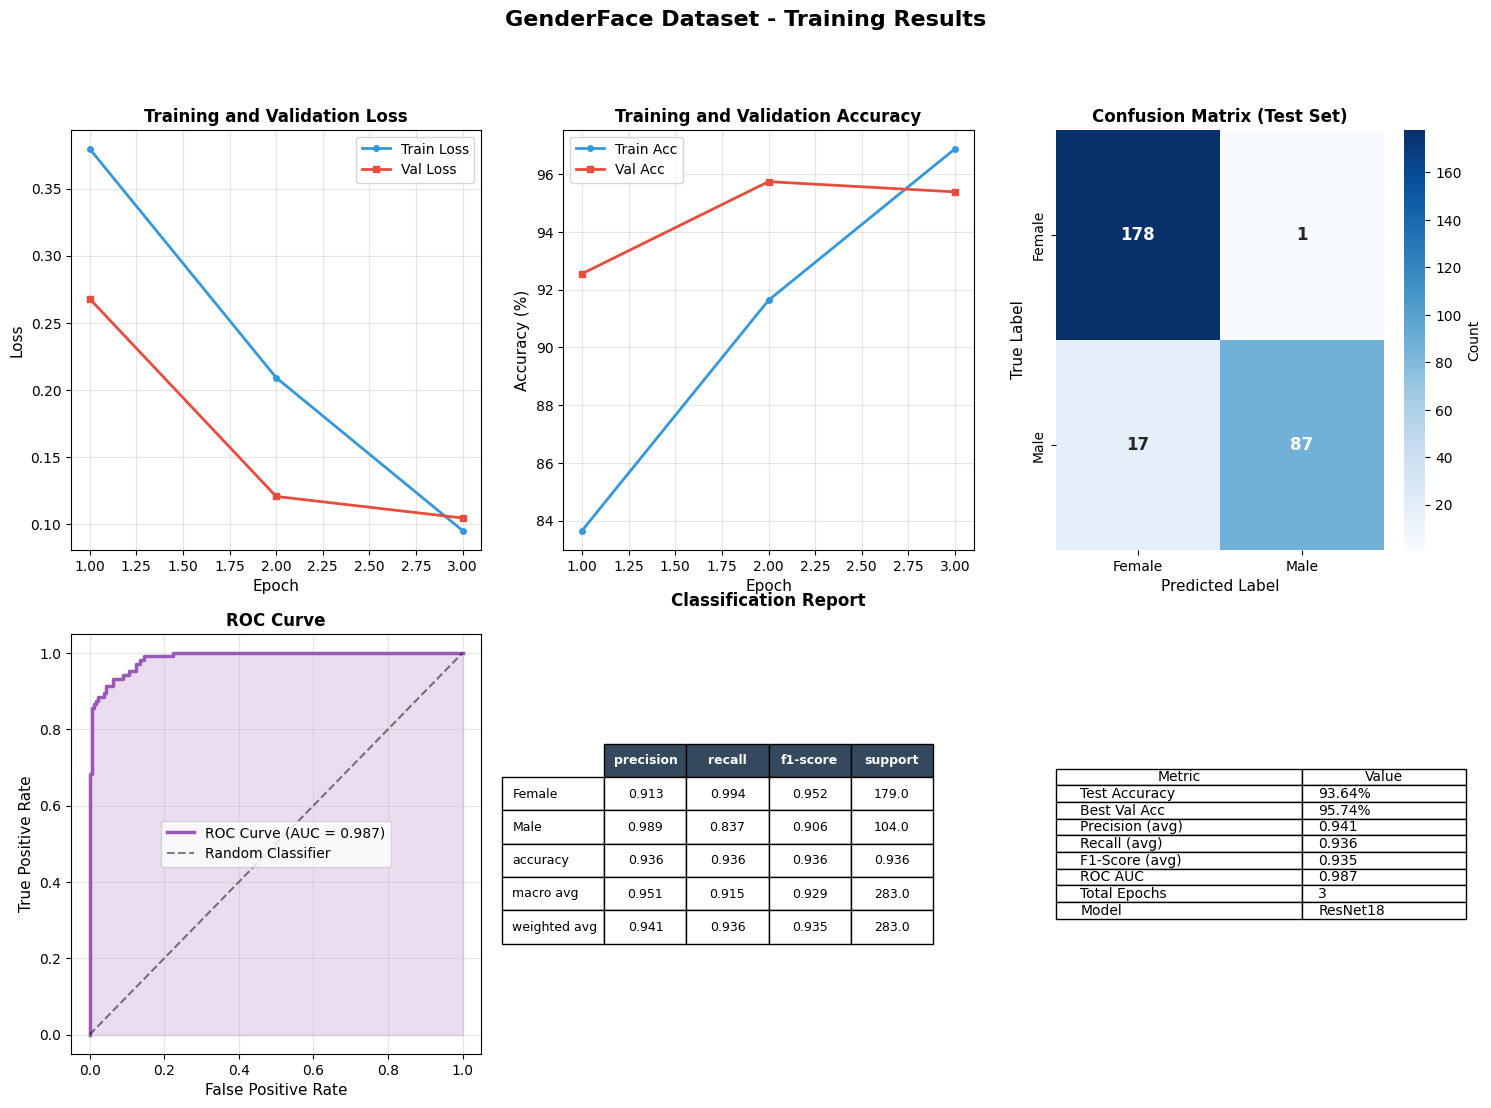

In [17]:
# ============================================================================
# 9. DATASET AND DATALOADER (MEMORY-EFFICIENT)
# ============================================================================

class GenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        # female=0, male=1
        for gender_idx, gender in enumerate(['female', 'male']):
            gender_dir = self.root_dir / gender
            if not gender_dir.exists():
                continue

            # Support multiple image formats
            for ext in ['*.jpg', '*.jpeg', '*.png']:
                for img_path in gender_dir.glob(ext):
                    self.samples.append((str(img_path), gender_idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            # Open image and immediately convert to RGB
            image = Image.open(img_path).convert('RGB')

            if self.transform:
                image = self.transform(image)

            return image, label

        except Exception as e:
            # Return a black image as fallback
            print(f"Error loading {img_path}: {e}")
            if self.transform:
                black_img = Image.new('RGB', (224, 224), color='black')
                return self.transform(black_img), label
            else:
                return torch.zeros(3, 224, 224), label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
print("\n" + "="*60)
print("CREATING DATASETS AND DATALOADERS")
print("="*60 + "\n")

train_dataset = GenderDataset(split_dir / 'train', transform=train_transform)
val_dataset = GenderDataset(split_dir / 'val', transform=test_transform)
test_dataset = GenderDataset(split_dir / 'test', transform=test_transform)

print(f"✓ Datasets created:")
print(f"  - Train: {len(train_dataset)} samples")
print(f"  - Val: {len(val_dataset)} samples")
print(f"  - Test: {len(test_dataset)} samples")

# Create dataloaders with memory-efficient settings
batch_size = 32
num_workers = 2  # Reduce if still having memory issues

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=num_workers, pin_memory=True,
                         persistent_workers=True if num_workers > 0 else False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=num_workers, pin_memory=True,
                       persistent_workers=True if num_workers > 0 else False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=num_workers, pin_memory=True,
                        persistent_workers=True if num_workers > 0 else False)

print("✓ DataLoaders created")

# Clean memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# ============================================================================
# 10. MODEL DEFINITION
# ============================================================================

class GenderClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(GenderClassifier, self).__init__()
        # Use ResNet18 as backbone
        self.backbone = models.resnet18(pretrained=pretrained)
        num_features = self.backbone.fc.in_features
        # Add dropout for regularization
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 2)
        )

    def forward(self, x):
        return self.backbone(x)

model = GenderClassifier(pretrained=True).to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Model created (ResNet18)")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")

# Clean memory
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# ============================================================================
# 11. TRAINING (MEMORY-EFFICIENT)
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

        # Clear cache periodically
        if total % 1000 == 0:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  patience=3, factor=0.5)

# Training loop
num_epochs = 3
best_val_acc = 0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print("\n" + "="*60)
print("STARTING TRAINING")
print("="*60 + "\n")

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_vggface2.pth')
        print(f"✓ Model saved (Val Acc: {val_acc:.2f}%) Kishan")

    # Memory cleanup
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%\n")

# ============================================================================
# 12. EVALUATION
# ============================================================================

def evaluate_model(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating', leave=False):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            # Clear cache
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# Load best model
model.load_state_dict(torch.load('best_model_vggface2.pth'))
print("Evaluating on test set...")
test_labels, test_preds, test_probs = evaluate_model(model, test_loader, device)

# Clean memory
gc.collect()

# ============================================================================
# 12. RESULTS VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('GenderFace Dataset - Training Results', fontsize=16, fontweight='bold')

# 1. Training and Validation Loss
ax = axes[0, 0]
epochs_range = range(1, len(history['train_loss']) + 1)
ax.plot(epochs_range, history['train_loss'], label='Train Loss', linewidth=2,
        color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_loss'], label='Val Loss', linewidth=2,
        color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 2. Training and Validation Accuracy
ax = axes[0, 1]
ax.plot(epochs_range, history['train_acc'], label='Train Acc', linewidth=2,
        color='#3498db', marker='o', markersize=4)
ax.plot(epochs_range, history['val_acc'], label='Val Acc', linewidth=2,
        color='#e74c3c', marker='s', markersize=4)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Accuracy (%)', fontsize=11)
ax.set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 3. Confusion Matrix
ax = axes[0, 2]
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Count'},
            xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'],
            annot_kws={'fontsize': 12, 'fontweight': 'bold'})
ax.set_title('Confusion Matrix (Test Set)', fontsize=12, fontweight='bold')
ax.set_ylabel('True Label', fontsize=11)
ax.set_xlabel('Predicted Label', fontsize=11)

# 4. ROC Curve
ax = axes[1, 0]
fpr, tpr, _ = roc_curve(test_labels, test_probs[:, 1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, linewidth=2.5, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='#9b59b6')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random Classifier', alpha=0.5)
ax.fill_between(fpr, tpr, alpha=0.2, color='#9b59b6')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# 5. Classification Report
ax = axes[1, 1]
ax.axis('off')
report = classification_report(test_labels, test_preds,
                               target_names=['Female', 'Male'],
                               output_dict=True)
report_df = pd.DataFrame(report).T.round(3)
report_df = report_df[['precision', 'recall', 'f1-score', 'support']]
table = ax.table(cellText=report_df.values, colLabels=report_df.columns,
                 rowLabels=report_df.index, cellLoc='center', loc='center',
                 colWidths=[0.2, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
for i in range(len(report_df.columns)):
    table[(0, i)].set_facecolor('#34495e')
    table[(0, i)].set_text_props(weight='bold', color='white')
ax.set_title('Classification Report', fontsize=12, fontweight='bold', pad=20)

# 6. Performance Metrics Summary
ax = axes[1, 2]
ax.axis('off')
test_acc = 100 * (test_preds == test_labels).mean()
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1 = report['weighted avg']['f1-score']

metrics_data = [
    ['Test Accuracy', f'{test_acc:.2f}%'],
    ['Best Val Acc', f'{best_val_acc:.2f}%'],
    ['Precision (avg)', f'{precision:.3f}'],
    ['Recall (avg)', f'{recall:.3f}'],
    ['F1-Score (avg)', f'{f1:.3f}'],
    ['ROC AUC', f'{roc_auc:.3f}'],
    ['Total Epochs', str(num_epochs)],
    ['Model', 'ResNet18']
]
table = ax.table(cellText=metrics_data, colLabels=['Metric', 'Value'],
                 cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
